# Assignment 2: Build a CNN for image recognition.

## Due Date:  March 27, 11:59PM

### Name: Lilli Nappi


## Introduction:

1. In this assignment, you will build Convolutional Neural Network to classify CIFAR-10 Images.
2. You can directly load dataset from many deep learning packages.
3. You can use any deep learning packages such as pytorch, keras or tensorflow for this assignment.

## Requirements:

1. You need to load cifar 10 data and split the entire training dataset into training and validation.
2. You will implement a CNN model to classify cifar 10 images with provided structure.
3. You need to plot the training and validation accuracy or loss obtained from above step.
4. Then you can use tuned parameters to train using the entire training dataset.
5. You should report the testing accuracy using the model with complete data.
6. You may try to change the structure (e.g, add BN layer or dropout layer,...) and analyze your findings.

## Google Colab

- If you do not have GPU, the training of a CNN can be slow. Google Colab is a good option.

## Batch Normalization (BN)

### Background:

- Batch Normalization is a technique to speed up training and help make the model more stable.
- In simple words, batch normalization is just another network layer that gets inserted between a hidden layer and the next hidden layer. Its job is to take the outputs from the first hidden layer and normalize them before passing them on as the input of the next hidden layer.

- For more detailed information, you may refer to the original paper: https://arxiv.org/pdf/1502.03167.pdf.

### BN Algorithm:

- Input: Values of $x$ over a mini-batch: $\mathbf{B}$ = $\{x_1,..., x_m\};$
- Output: $\{y_i = BN_{\gamma,\beta}(x_i)\}$, $\gamma, \beta$ are learnable parameters

Normalization of the Input:
$$\mu_{\mathbf{B}} = \frac{1}{m}\sum_{i=1}^m x_i$$
$$\sigma_{\mathbf{B}}^2 = \frac{1}{m}\sum_{i=1}^m (x_i - \mu_{\mathbf{B}})^2$$
$$\hat{x_i} = \frac{x_i - \mu_{\mathbf{B}}}{\sqrt{\sigma_{\mathbf{B}}}^2 + \epsilon}$$
Re-scaling and Offsetting:
$$y_i = \gamma \hat{x_i} + \beta = BN_{\gamma,\beta}(x_i)$$


### Advantages of BN:
1. Improves gradient flow through the network.
2. Allows use of saturating nonlinearities and higher learning rates.
3. Makes weights easier to initialize.
4. Act as a form of regularization and may reduce the need for dropout.

### Implementation:

- The batch normalization layer has already been implemented in many packages. You may simply call the function to build the layer. For example: torch.nn.BatchNorm2d() using pytroch package, keras.layers.BatchNormalization() using keras package.
- The location of BN layer: Please make sure ```BatchNormalization``` is between a ```Conv```/```Dense``` layer and an ```activation``` layer.

## 1. Data preparation

### 1.1. Load data


In [109]:
# Load Cifar-10 Data
# This is just an example, you may load dataset from other packages.
import keras
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Activation, BatchNormalization
from keras.models import Sequential
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline


### If you can not load keras dataset, un-comment these two lines.
#import ssl
#ssl._create_default_https_context = ssl._create_unverified_context

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

print('shape of x_train: ' + str(x_train.shape))
print('shape of y_train: ' + str(y_train.shape))
print('shape of x_test: ' + str(x_test.shape))
print('shape of y_test: ' + str(y_test.shape))
print('number of classes: ' + str(np.max(y_train) - np.min(y_train) + 1))

shape of x_train: (50000, 32, 32, 3)
shape of y_train: (50000, 1)
shape of x_test: (10000, 32, 32, 3)
shape of y_test: (10000, 1)
number of classes: 10


### 1.2. One-hot encode the labels (5 points)

In the input, a label is a scalar in $\{0, 1, \cdots , 9\}$. One-hot encode transform such a scalar to a $10$-dim vector. E.g., a scalar ```y_train[j]=3``` is transformed to the vector ```y_train_vec[j]=[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]```.

1. Implement a function ```to_one_hot``` that transforms an $n\times 1$ array to a $n\times 10$ matrix.

2. Apply the function to ```y_train``` and ```y_test```.

In [110]:
def to_one_hot(y, num_class=10):
    result = np.zeros((len(y), num_class))
    for i, y in enumerate(y):
        result[i, y] = 1
    return result

y_train_vec = to_one_hot(y_train)
y_test_vec = to_one_hot(y_test)

print('Shape of y_train_vec: ' + str(y_train_vec.shape))
print('Shape of y_test_vec: ' + str(y_test_vec.shape))

print(y_train[0])
print(y_train_vec[0])

Shape of y_train_vec: (50000, 10)
Shape of y_test_vec: (10000, 10)
[6]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


#### Remark: the outputs should be
* Shape of y_train_vec: (50000, 10)
* Shape of y_test_vec: (10000, 10)
* [6]
* [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]

### 1.3. Randomly partition the training set to training and validation sets (5 points)

Randomly partition the 50K training samples to 2 sets: 
* a training set containing 40K samples: x_tr, y_tr
* a validation set containing 10K samples: x_val, y_val


In [111]:
x_tr, x_val, y_tr, y_val = train_test_split(x_train, y_train_vec, test_size=0.2, random_state=0)

print('Shape of x_tr: ' + str(x_tr.shape))
print('Shape of y_tr: ' + str(y_tr.shape))
print('Shape of x_val: ' + str(x_val.shape))
print('Shape of y_val: ' + str(y_val.shape))

Shape of x_tr: (40000, 32, 32, 3)
Shape of y_tr: (40000, 10)
Shape of x_val: (10000, 32, 32, 3)
Shape of y_val: (10000, 10)


## 2. Build a CNN and tune its hyper-parameters (50 points)

- Build a convolutional neural network model using the below structure:

- It should have a structure of: Conv - ReLU - Max Pool - ConV - ReLU - Max Pool - Dense - ReLU - Dense - Softmax

- In the graph 3@32x32 means the dimension of input image, 32@30x30 means it has 32 filters and the dimension now becomes 30x30 after the convolution.
- All convolutional layers (Conv) should have stride = 1 and no padding.
- Max Pooling has a pool size of 2 by 2.




<img src="network.PNG"/>

- You may use the validation data to tune the hyper-parameters (e.g., learning rate, and optimization algorithm)
- Do NOT use test data for hyper-parameter tuning!!!
- Try to achieve a validation accuracy as high as possible.

In [112]:
# Build the model
model = Sequential()

model.add(Conv2D(32, (3,3), activation='relu', strides=1, input_shape=(32,32,3)))
model.add(MaxPooling2D(2,2)) # has pool size of 2 by 2

model.add(Conv2D(64, (4,4), activation='relu'))
model.add(MaxPooling2D(2,2)) # has pool size of 2 by 2

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_28 (Conv2D)              │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 12, 12, 64)     │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 256)            │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 626,378 (2.39 MB)

 Trainable params: 626,378 (2.39 MB)

 Non-trainable params: 0 (0.00 B)

In [113]:
# Define model optimizer and loss function
model.compile(optimizer=optimizers.RMSprop(0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [114]:
# Train the model and store model parameters/loss values
train = model.fit(x_tr, y_tr, batch_size=128, epochs=15, validation_data=(x_val, y_val))

Epoch 1/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 39ms/step - accuracy: 0.2063 - loss: 10.7872 - val_accuracy: 0.3174 - val_loss: 2.3101
Epoch 2/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - accuracy: 0.3901 - loss: 1.8243 - val_accuracy: 0.4566 - val_loss: 1.5525
Epoch 3/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.5088 - loss: 1.4223 - val_accuracy: 0.5018 - val_loss: 1.4255
Epoch 4/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.5713 - loss: 1.2359 - val_accuracy: 0.5403 - val_loss: 1.3370
Epoch 5/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - accuracy: 0.6171 - loss: 1.0935 - val_accuracy: 0.5254 - val_loss: 1.4565
Epoch 6/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - accuracy: 0.6611 - loss: 0.9914 - val_accuracy: 0.5530 - val_loss: 1.3304
Epoch 7/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - accuracy: 0.7021 - loss: 0.8784 - val_accuracy: 0.5775 - val_loss: 1.2940
Epoch 8/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.7306 - loss: 0.7883 -

## 3. Plot the training and validation loss curve versus epochs. (5 points)

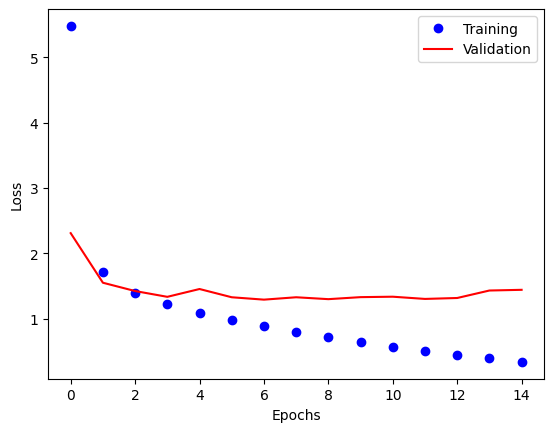

In [115]:
# Plot the loss curve

plt.plot(range(15), train.history['loss'], 'bo', label='Training')
plt.plot(range(15), train.history['val_loss'], 'r', label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 4. Train (again) and evaluate the model (5 points)

- To this end, you have found the "best" hyper-parameters. 
- Now, fix the hyper-parameters and train the network on the entire training set (all the 50K training samples)
- Evaluate your model on the test set.

### Train the model on the entire training set

Why? Previously, you used 40K samples for training; you wasted 10K samples for the sake of hyper-parameter tuning. Now you already know the hyper-parameters, so why not using all the 50K samples for training?

In [63]:
#<Compile your model again (using the same hyper-parameters you tuned above)>
model.compile(optimizer=optimizers.RMSprop(0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [64]:
#<Train your model on the entire training set (50K samples)>
train = model.fit(x_train, y_train_vec, batch_size=128, epochs= 30, validation_data=(x_val, y_val))

Epoch 1/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9092 - loss: 0.4534 - val_accuracy: 0.7136 - val_loss: 1.1034
Epoch 2/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 17s 43ms/step - accuracy: 0.9315 - loss: 0.2837 - val_accuracy: 0.7711 - val_loss: 0.7893
Epoch 3/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 17s 42ms/step - accuracy: 0.9488 - loss: 0.2019 - val_accuracy: 0.8415 - val_loss: 0.5176
Epoch 4/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 17s 43ms/step - accuracy: 0.9618 - loss: 0.1453 - val_accuracy: 0.8921 - val_loss: 0.3352
Epoch 5/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9725 - loss: 0.1017 - val_accuracy: 0.9297 - val_loss: 0.2255
Epoch 6/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.9792 - loss: 0.0788 - val_accuracy: 0.9634 - val_loss: 0.1308
Epoch 7/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 19s 49ms/step - accuracy: 0.9856 - loss: 0.0582 - val_accuracy: 0.9593 - val_loss: 0.1290
Epoch 8/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 19s 48ms/step - accuracy: 0.9893 - loss: 0.0467 - 

## 5. Evaluate the model on the test set (5 points)

Do NOT used the test set until now. Make sure that your model parameters and hyper-parameters are independent of the test set.

In [122]:
# Evaluate your model performance (testing accuracy) on testing data.
loss_and_acc = model.evaluate(x_test, y_test_vec)
print('loss = ' + str(loss_and_acc[0]))
print('accuracy = ' + str(loss_and_acc[1]))

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1036 - loss: 2.3026
loss = 2.3025929927825928
accuracy = 0.10000000149011612


## 6. Building model with new structure (25 points)
- In this section, you can build your model with adding new layers (e.g, BN layer or dropout layer, ...)
- If you want to regularize a ```Conv/Dense layer```, you should place a ```Dropout layer``` before the ```Conv/Dense layer```.
- You can try to compare their loss curve and testing accuracy and analyze your findings.
- You need to try at lease two different structures.

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_40 (Conv2D)              │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_40 (MaxPooling2D) │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 12, 12, 64)     │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_41 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_20 (Flatten)            │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 256)            │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 626,378 (2.39 MB)

 Trainable params: 626,378 (2.39 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.1428 - loss: 30.5965 - val_accuracy: 0.1790 - val_loss: 2.1863
Epoch 2/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.2118 - loss: 2.1449 - val_accuracy: 0.3204 - val_loss: 1.8511
Epoch 3/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 18s 59ms/step - accuracy: 0.3152 - loss: 1.8663 - val_accuracy: 0.3920 - val_loss: 1.6699
Epoch 4/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 18s 58ms/step - accuracy: 0.3823 - loss: 1.6940 - val_accuracy: 0.4144 - val_loss: 1.6206
Epoch 5/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 62ms/step - accuracy: 0.4254 - loss: 1.5874 - val_accuracy: 0.4100 - val_loss: 1.6416
Epoch 6/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 18s 57ms/step - accuracy: 0.4483 - loss: 1.5189 - val_accuracy: 0.4358 - val_loss: 1.5456
Epoch 7/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 59ms/step - accuracy: 0.4753 - loss: 1.4590 - val_accuracy: 0.4323 - val_loss: 1.5552
Epoch 8/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 18s 56ms/step - accuracy: 0.4968 - loss: 1.4005 -

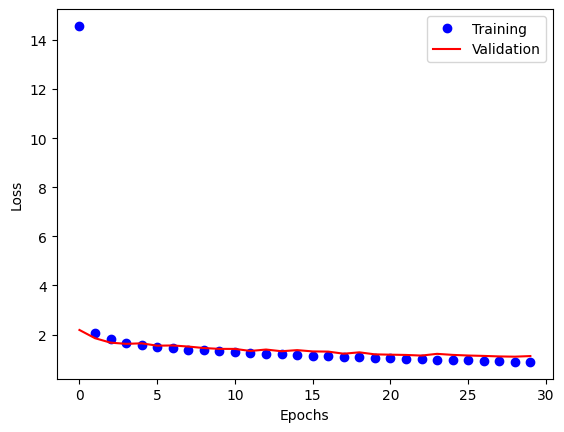

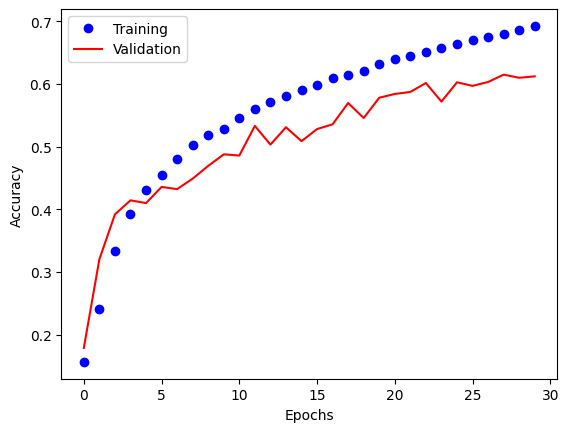

In [125]:
# First Structure: accuracy was slower to obtain than previous stucture and loss remained almost consistent
model = Sequential()

model.add(Conv2D(32, (3,3), activation='relu', strides=1, input_shape=(32,32,3)))
model.add(MaxPooling2D(2,2)) # has pool size of 2 by 2
model.add(Dropout(0.5)) # regularize

model.add(Conv2D(64, (4,4), activation='relu'))
model.add(MaxPooling2D(2,2)) # has pool size of 2 by 2

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.summary()


model.compile(optimizer=optimizers.RMSprop(0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
train = model.fit(x_tr, y_tr, batch_size=128, epochs= 30, validation_data=(x_val, y_val))

plt.plot(range(30), train.history['loss'], 'bo', label='Training')
plt.plot(range(30), train.history['val_loss'], 'r', label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(range(30), train.history['accuracy'], 'bo', label='Training')
plt.plot(range(30), train.history['val_accuracy'], 'r', label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_42 (Conv2D)              │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_42 (MaxPooling2D) │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 12, 12, 64)     │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 12, 12, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_43 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_21 (Flatten)            │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 256)            │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 626,762 (2.39 MB)

 Trainable params: 626,570 (2.39 MB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 78ms/step - accuracy: 0.3548 - loss: 1.8061 - val_accuracy: 0.5029 - val_loss: 1.4080
Epoch 2/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 79ms/step - accuracy: 0.5421 - loss: 1.2926 - val_accuracy: 0.5494 - val_loss: 1.2690
Epoch 3/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 79ms/step - accuracy: 0.6027 - loss: 1.1280 - val_accuracy: 0.5975 - val_loss: 1.1438
Epoch 4/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 83ms/step - accuracy: 0.6392 - loss: 1.0317 - val_accuracy: 0.6055 - val_loss: 1.1117
Epoch 5/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 86ms/step - accuracy: 0.6702 - loss: 0.9443 - val_accuracy: 0.6123 - val_loss: 1.1198
Epoch 6/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 28s 89ms/step - accuracy: 0.6941 - loss: 0.8821 - val_accuracy: 0.6487 - val_loss: 1.0069
Epoch 7/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 83ms/step - accuracy: 0.7144 - loss: 0.8233 - val_accuracy: 0.6568 - val_loss: 0.9840
Epoch 8/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 81ms/step - accuracy: 0.7335 - loss: 0.7791 - 

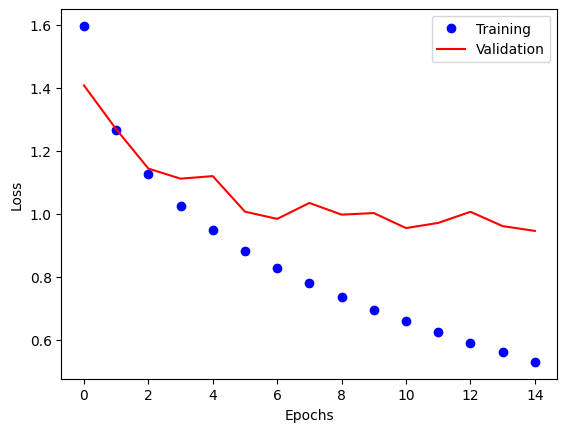

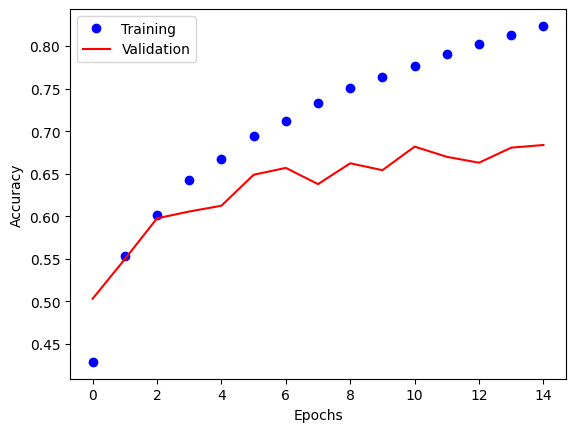

In [126]:
# Second Structure: accuracy increased much faster comparitavely and loss decreased much quicker comparitely as well
# However validation loss and accuracy fluctuated much more than the previous structure
model = Sequential()

model.add(Conv2D(32, (3,3), strides=1, input_shape=(32,32,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(2,2)) # has pool size of 2 by 2

model.add(Conv2D(64, (4,4)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(2,2)) # has pool size of 2 by 2

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.summary()


model.compile(optimizer=optimizers.RMSprop(0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
train = model.fit(x_tr, y_tr, batch_size=128, epochs= 15, validation_data=(x_val, y_val))

plt.plot(range(15), train.history['loss'], 'bo', label='Training')
plt.plot(range(15), train.history['val_loss'], 'r', label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(range(15), train.history['accuracy'], 'bo', label='Training')
plt.plot(range(15), train.history['val_accuracy'], 'r', label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()